# **Time Series**

## **Data Time Series NO2 daerah Bangkalan**
Satelit Sentinel-5P (TROPOMI) dari program Copernicus digunakan untuk memantau kualitas udara global, khususnya konsentrasi gas-gas seperti nitrogen dioksida (NO₂), karbon monoksida (CO), ozon (O₃), dan metana (CH₄).
Gas NO₂ merupakan indikator utama polusi udara yang berasal dari aktivitas manusia seperti kendaraan bermotor, industri, dan pembakaran bahan bakar fosil.

Wilayah bangkalan dipilih sebagai area pengamatan untuk menganalisis dinamika NO₂ selama periode 2022:–2025.

In [2]:
pip install openeo


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [9]:
import openeo
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from openeo.rest.datacube import Polygon
from sklearn.model_selection import train_test_split
import glob

In [4]:
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=RNLR-PEWP 📋 to authenticate.

✅ Authorized successfully

Authenticated using device code flow.


In [5]:
aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [112.76899595080619, -7.019806638755355],  # Titik 1 (Timur Laut)
            [112.72040940932828, -7.019806638755355],  # Titik 2 (Barat Laut)
            [112.72040940932828, -7.06499820241666],   # Titik 3 (Barat Daya)
            [112.76899595080619, -7.06499820241666],   # Titik 4 (Tenggara)
            [112.76899595080619, -7.019806638755355],  # Kembali ke Titik 1
        ]
    ],
}


In [6]:
# Mengambil data NO2 Sentinel-5P berdasarkan AOI dan rentang waktu
s5p_no2 = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=["2022-10-19", "2025-10-19"],
    spatial_extent={
        "west": 112.72040940932828,
        "south": -7.06499820241666,
        "east": 112.76899595080619,
        "north": -7.019806638755355,
    },
    bands=["NO2"],
)

In [7]:
s5p_no2_daily = s5p_no2.aggregate_temporal_period(
    period="day",
    reducer="mean"
)

# Agregasi spasial: rata-rata di dalam area poligon
s5p_no2_avg = s5p_no2_daily.aggregate_spatial(
    reducer="mean",
    geometries=aoi
)

# Eksekusi batch job dan simpan hasilnya ke file CSV
job = s5p_no2_avg.execute_batch(
    title="NO2 Harian di Bangkalan (2022–2025)",
    outputfile="no2_bangkalan_timeseries.csv",
    format="CSV"
)

0:00:00 Job 'j-2510261641124b29866600b847f73679': send 'start'
0:00:13 Job 'j-2510261641124b29866600b847f73679': created (progress 0%)
0:00:19 Job 'j-2510261641124b29866600b847f73679': created (progress 0%)
0:00:25 Job 'j-2510261641124b29866600b847f73679': created (progress 0%)
0:00:33 Job 'j-2510261641124b29866600b847f73679': created (progress 0%)
0:00:43 Job 'j-2510261641124b29866600b847f73679': created (progress 0%)
0:00:56 Job 'j-2510261641124b29866600b847f73679': created (progress 0%)
0:01:12 Job 'j-2510261641124b29866600b847f73679': running (progress N/A)
0:01:31 Job 'j-2510261641124b29866600b847f73679': running (progress N/A)
0:01:56 Job 'j-2510261641124b29866600b847f73679': running (progress N/A)
0:02:26 Job 'j-2510261641124b29866600b847f73679': running (progress N/A)
0:03:04 Job 'j-2510261641124b29866600b847f73679': running (progress N/A)
0:03:50 Job 'j-2510261641124b29866600b847f73679': running (progress N/A)
0:04:49 Job 'j-2510261641124b29866600b847f73679': running (progress

In [10]:
# Buat folder dan unduh hasil job ke sana
job.get_results().download_files(target="results/")

# Cari file CSV di folder results
csv_file = glob.glob("results/*.csv")[0]

# Baca dan tampilkan
df_no2 = pd.read_csv(csv_file)
print(df_no2)

                          date  feature_index       NO2
0     2022-11-21T00:00:00.000Z              0       NaN
1     2022-11-17T00:00:00.000Z              0  0.000016
2     2022-11-23T00:00:00.000Z              0       NaN
3     2022-11-18T00:00:00.000Z              0       NaN
4     2022-11-20T00:00:00.000Z              0       NaN
...                        ...            ...       ...
1092  2025-03-20T00:00:00.000Z              0       NaN
1093  2025-03-19T00:00:00.000Z              0       NaN
1094  2025-03-13T00:00:00.000Z              0       NaN
1095  2025-03-14T00:00:00.000Z              0       NaN
1096  2025-03-15T00:00:00.000Z              0       NaN

[1097 rows x 3 columns]


## **Processing Data**

Jumlah missing values sebelum interpolasi:
date               0
feature_index      0
NO2              639
dtype: int64

✅ Data setelah interpolasi tersimpan sebagai 'no2_bangkalan_timeseries_clean.csv'
                         date  feature_index       NO2
863 2022-10-18 00:00:00+00:00              0  0.000028
862 2022-10-19 00:00:00+00:00              0  0.000028
861 2022-10-20 00:00:00+00:00              0  0.000028
860 2022-10-21 00:00:00+00:00              0  0.000028
864 2022-10-22 00:00:00+00:00              0  0.000028


/tmp/ipykernel_5570/940646867.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_no2['NO2'] = df_no2['NO2'].fillna(method='bfill').fillna(method='ffill')


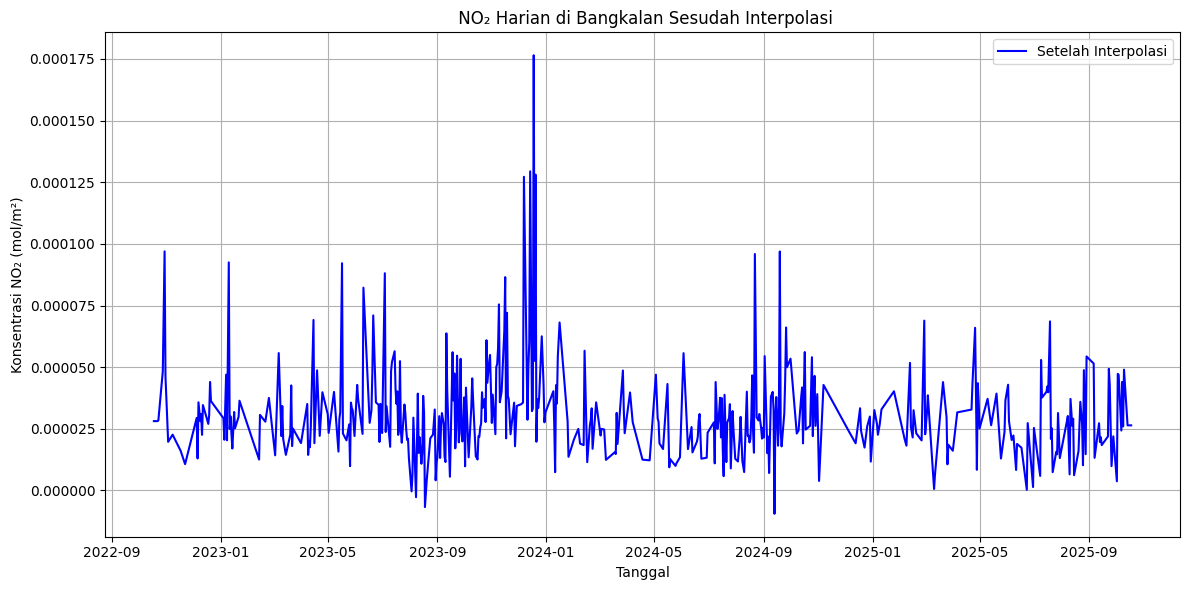

In [11]:
# Membaca file CSV hasil dari openEO
df_no2 = pd.read_csv("no2_bangkalan_timeseries.csv")

# Pastikan kolom tanggal dan urutkan
df_no2['date'] = pd.to_datetime(df_no2['date'])
df_no2 = df_no2.sort_values('date')

# Cek missing values
print("Jumlah missing values sebelum interpolasi:")
print(df_no2.isna().sum())

# Interpolasi linear untuk mengisi missing values
df_no2['NO2'] = df_no2['NO2'].interpolate(method='linear')

# Isi sisa NaN di awal/akhir dengan nilai terdekat
df_no2['NO2'] = df_no2['NO2'].fillna(method='bfill').fillna(method='ffill')

# Simpan hasil data bersih ke file baru
df_no2.to_csv("no2_bangkalan_timeseries_clean.csv", index=False)

print("\n✅ Data setelah interpolasi tersimpan sebagai 'no2_bangkalan_timeseries_clean.csv'")
print(df_no2.head())

# Visualisasi sebelum dan sesudah interpolasi

plt.figure(figsize=(12,6))
plt.plot(df_no2['date'], df_no2['NO2'], label='Setelah Interpolasi', color='blue')

plt.title(" NO₂ Harian di Bangkalan Sesudah Interpolasi")
plt.xlabel("Tanggal")
plt.ylabel("Konsentrasi NO₂ (mol/m²)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### **Data Supervised**
Data supervised adalah bentuk data yang sudah memiliki fitur input (X) dan target output (y).
Dalam konteks time series (seperti data NO₂ harian), kita membentuk data supervised agar model bisa memprediksi nilai masa depan berdasarkan data sebelumnya.

In [12]:
# Membaca data hasil interpolasi
df_no2 = pd.read_csv("no2_bangkalan_timeseries_clean.csv")

# Pastikan urut berdasarkan tanggal
df_no2['date'] = pd.to_datetime(df_no2['date'])
df_no2 = df_no2.sort_values('date')

# --- Atur jumlah lag (berapa hari sebelumnya yang dijadikan input) ---
n_lags = 3  # contoh: gunakan 3 hari terakhir untuk prediksi hari ke-4

# --- Membentuk fitur lag ---
for i in range(1, n_lags + 1):
    df_no2[f'NO2_t-{i}'] = df_no2['NO2'].shift(i)

# --- Kolom target (nilai NO2 hari ini) ---
df_supervised = df_no2.dropna().reset_index(drop=True)

# Simpan hasilnya
df_supervised.to_csv("no2_bangkalan_supervised.csv", index=False)

print("✅ Data supervised berhasil dibuat dan disimpan sebagai 'no2_bangkalan_supervised.csv'")
print(df_supervised.head())

✅ Data supervised berhasil dibuat dan disimpan sebagai 'no2_bangkalan_supervised.csv'
                       date  feature_index       NO2   NO2_t-1   NO2_t-2  \
0 2022-10-21 00:00:00+00:00              0  0.000028  0.000028  0.000028   
1 2022-10-22 00:00:00+00:00              0  0.000028  0.000028  0.000028   
2 2022-10-23 00:00:00+00:00              0  0.000028  0.000028  0.000028   
3 2022-10-24 00:00:00+00:00              0  0.000032  0.000028  0.000028   
4 2022-10-25 00:00:00+00:00              0  0.000036  0.000032  0.000028   

    NO2_t-3  
0  0.000028  
1  0.000028  
2  0.000028  
3  0.000028  
4  0.000028  


### **Normalisasi data**
Normalisasi dilakukan agar semua nilai berada dalam skala yang sama — ini penting karena algoritma seperti KNN, SVM, atau Neural Network sensitif terhadap perbedaan skala.

Tanpa normalisasi, fitur dengan skala besar (misal 1000) bisa mendominasi fitur lain (misal 0.1)

In [13]:
# Baca ulang data supervised
df_supervised = pd.read_csv("no2_bangkalan_supervised.csv")

# Hapus kolom waktu (misalnya 'date')
df_supervised = df_supervised.drop(columns=["date"], errors="ignore")

# Pisahkan fitur dan target
X = df_supervised.drop(columns=["NO2"])
y = df_supervised["NO2"]

# Normalisasi dengan Min-Max
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Gabungkan hasil
df_scaled_minmax = pd.DataFrame(X_scaled, columns=X.columns)
df_scaled_minmax["NO2"] = y.values

# Simpan hasil
df_scaled_minmax.to_csv("no2_bangkalan_normalized_minmax.csv", index=False)

print("✅ Normalisasi (Min-Max) selesai dan disimpan sebagai 'no2_bangkalan_normalized_minmax.csv'")
print(df_scaled_minmax.head())


✅ Normalisasi (Min-Max) selesai dan disimpan sebagai 'no2_bangkalan_normalized_minmax.csv'
   feature_index   NO2_t-1   NO2_t-2   NO2_t-3       NO2
0            0.0  0.202077  0.202077  0.202077  0.000028
1            0.0  0.202077  0.202077  0.202077  0.000028
2            0.0  0.202077  0.202077  0.202077  0.000028
3            0.0  0.203332  0.202077  0.202077  0.000032
4            0.0  0.224862  0.203332  0.202077  0.000036


## **Modeling dengan K-NN regression**
KNN Regression adalah metode non-parametrik yang memprediksi nilai keluaran (target) berdasarkan kedekatan (similarity) antara data baru dengan data lama.
Berbeda dengan model yang mencari fungsi matematis, KNN hanya mengandalkan jarak antar data.

In [14]:
# Baca data hasil normalisasi
df = pd.read_csv("no2_bangkalan_normalized_minmax.csv")

# Pastikan hanya ambil kolom NO2
df = df[['NO2']]

# Fungsi membentuk supervised data dengan lag
def make_supervised(data, lag=1):
    df_supervised = pd.DataFrame()
    for i in range(1, lag + 1):
        df_supervised[f'NO2_lag_{i}'] = data['NO2'].shift(i)
    df_supervised['NO2'] = data['NO2']
    df_supervised = df_supervised.dropna()
    return df_supervised




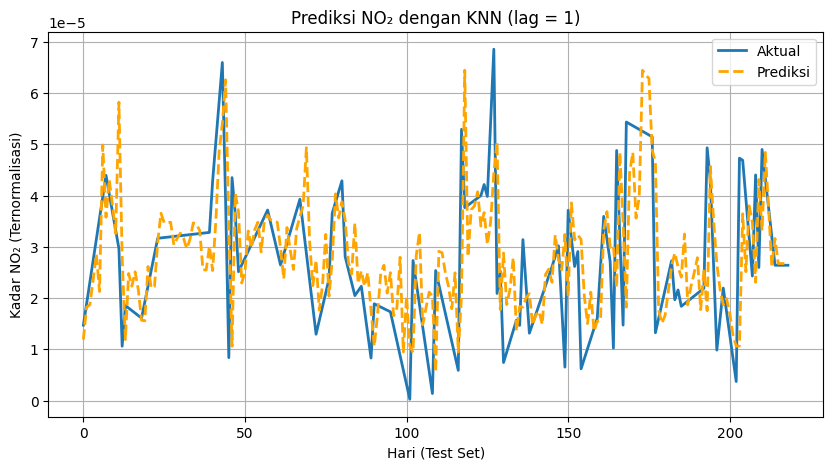

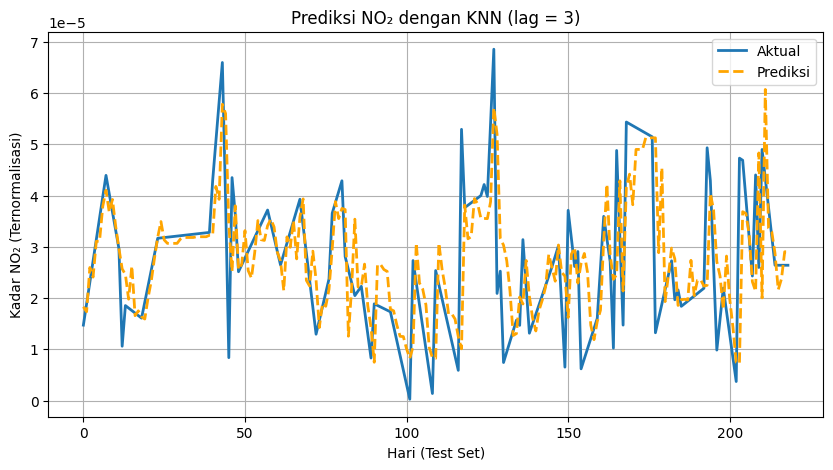

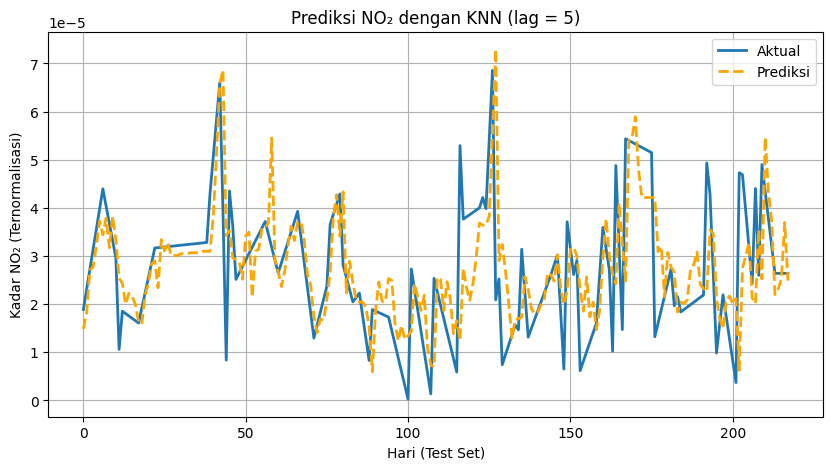

📊 Hasil Eksperimen KNN Regression:
   lag           MSE        R2
0    1  1.263429e-10  0.242656
1    3  9.831566e-11  0.410661
2    5  1.096082e-10  0.343251


In [15]:
# Eksperimen dengan beberapa lag
lag_values = [1, 3, 5]
results = []

for lag in lag_values:
    df_lag = make_supervised(df, lag)
    
    X = df_lag.drop(columns=['NO2'])
    y = df_lag['NO2']

    # Bagi data train-test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    # Model KNN Regression
    knn = KNeighborsRegressor(n_neighbors=5)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    # Evaluasi
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'lag': lag,
        'MSE': mse,
        'R2': r2
    })

    # Visualisasi prediksi vs aktual
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(y_test)), y_test, label="Aktual", linewidth=2)
    plt.plot(range(len(y_test)), y_pred, label="Prediksi", linestyle='--', color='orange', linewidth=2)
    plt.title(f"Prediksi NO₂ dengan KNN (lag = {lag})")
    plt.xlabel("Hari (Test Set)")
    plt.ylabel("Kadar NO₂ (Ternormalisasi)")
    plt.legend()
    plt.grid(True)
    plt.show()

#  Rekap hasil eksperimen
results_df = pd.DataFrame(results)
print("📊 Hasil Eksperimen KNN Regression:")
print(results_df)

# Simpan hasil ke CSV
results_df.to_csv("hasil_knn_regression_bangkalan.csv", index=False)

## **Hasil eksperimen KNN Regressionn**
Makna kolom:
- Lag → jumlah hari ke belakang yang digunakan sebagai input (misalnya lag=3 berarti memprediksi NO₂ hari ini berdasarkan 3 hari sebelumnya).

- MSE (Mean Squared Error) → semakin kecil nilainya, semakin baik akurasi model (kesalahan prediksi kecil).

- R² (Koefisien Determinasi) → menunjukkan seberapa baik model menjelaskan variasi data.
Nilai mendekati 1 berarti prediksi sangat baik, mendekati 0 berarti lemah.

Interpretasi Hasil
- Pada lag = 1, model hanya melihat 1 hari sebelumnya → hasil R² = 0.24 (masih lemah).
Artinya, informasi dari 1 hari saja belum cukup untuk menangkap pola perubahan NO₂.

- Pada lag = 3, R² naik menjadi 0.41 dan MSE paling kecil (9.83e-11)
→ ini model terbaik, karena kesalahan paling kecil dan akurasi paling tinggi.
Pola perubahan NO₂ tampaknya dipengaruhi oleh 3 hari terakhir.

- Pada lag = 5, performa turun sedikit (R² = 0.34)
→ kemungkinan karena terlalu banyak lag, model jadi kurang fokus (overfitting) atau data historis yang terlalu lama kurang relevan dengan kondisi saat ini.

Kesimpulan

- Model terbaik: KNN dengan lag = 3.

- Makna: Konsentrasi NO₂ harian di wilayah Bangkalan paling baik diprediksi dengan mempertimbangkan tiga hari sebelumnya.

- Implikasi: Pola pencemaran udara NO₂ memiliki pengaruh temporal jangka pendek (3 hari), di mana kondisi hari ini sangat dipengaruhi oleh beberapa hari terakhir.